# Stock Price Prediction Project
3 models are implemented:
1. Linear Regression (Baseline)
2. XGBoost (Advanced ensemble method)
3. Facebook Prophet (Time-series forecasting)



In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from prophet import Prophet

### Data Prepration

In [37]:
df = pd.read_csv(r"C:\03_MISC\UM\TCS_stock_dataset.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0


In [38]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463 entries, 0 to 4462
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          4463 non-null   object 
 1   Open          4463 non-null   float64
 2   High          4463 non-null   float64
 3   Low           4463 non-null   float64
 4   Close         4463 non-null   float64
 5   Volume        4463 non-null   int64  
 6   Dividends     4463 non-null   float64
 7   Stock Splits  4463 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 279.1+ KB


In [40]:
df.shape

(4463, 8)

## Data Preprocessing

In [41]:
df.isna().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [42]:
df.drop_duplicates()
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0


In [43]:
df['Date'] = pd.to_datetime(df['Date'])
df=df.sort_values(by= 'Date')

In [44]:
df.describe()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,4463,4463.000000,4463.000000,4463.000000,4463.000000,4.463000e+03,4463.000000,4463.000000
mean,2012-08-23 19:22:31.109119488,866.936239,876.675013,856.653850,866.537398,3.537876e+06,0.071533,0.001344
min,2002-08-12 00:00:00,24.146938,27.102587,24.146938,26.377609,0.000000e+00,0.000000,0.000000
25%,2008-02-14 12:00:00,188.951782,191.571816,185.979417,188.594620,1.860959e+06,0.000000,0.000000
50%,2012-09-04 00:00:00,530.907530,534.751639,525.616849,529.713257,2.757742e+06,0.000000,0.000000
75%,2017-03-22 12:00:00,1156.462421,1165.815854,1143.622800,1154.784851,4.278625e+06,0.000000,0.000000
max,2021-09-30 00:00:00,3930.000000,3981.750000,3892.100098,3954.550049,8.806715e+07,40.000000,2.000000
std,NaN,829.905368,838.267104,821.233477,829.611313,3.273531e+06,0.965401,0.051842


In [45]:
# correlation
corel =df.corr()
corel

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,1.000000,0.899114,0.899354,0.898962,0.899214,-0.177351,0.062321,-0.005701
Open,0.899114,1.000000,0.999888,0.999892,0.999787,-0.153362,0.059743,-0.006715
High,0.899354,0.999888,1.000000,0.999867,0.999914,-0.150918,0.060044,-0.006597
Low,0.898962,0.999892,0.999867,1.000000,0.999901,-0.154962,0.059916,-0.006622
Close,0.899214,0.999787,0.999914,0.999901,1.000000,-0.152844,0.060179,-0.006635
Volume,-0.177351,-0.153362,-0.150918,-0.154962,-0.152844,1.000000,-0.010332,0.004752
Dividends,0.062321,0.059743,0.060044,0.059916,0.060179,-0.010332,1.000000,0.142493
Stock Splits,-0.005701,-0.006715,-0.006597,-0.006622,-0.006635,0.004752,0.142493,1.000000


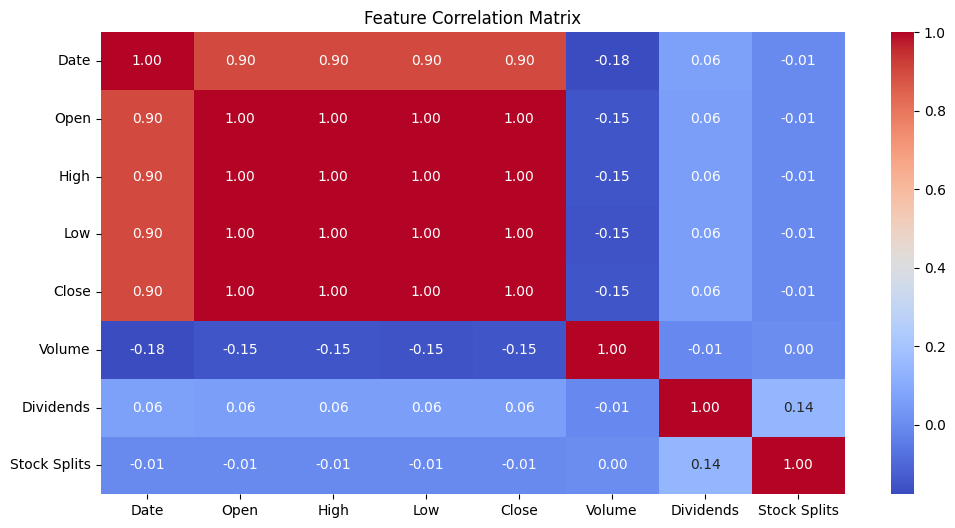

In [46]:
# ploting correlation
correlation_with_close= df.corr()['Close'].sort_values(ascending=False)
#print(correlation_with_close)
plt.figure(figsize=(12, 6))
sns.heatmap(corel,annot= True,cmap= "coolwarm",fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [47]:
# feature engineering
df['Close_t-2'] = df['Close'].shift(2)  
df['Close_t-1'] = df['Close'].shift(1) 

df['Price_Change'] = df['Close'].diff()

df['Volatility'] = df['High'] - df['Low']

df['MA_3'] = df['Close'].rolling(window=3).mean()
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_14'] = df['Close'].rolling(window=14).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()

df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()

df['MACD'] = df['EMA_12'] - df['EMA_26']

def compute_rsi(series, window=14):
    delta = series.diff()
    
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # Use exponential moving averages
    avg_gain = gain.ewm(alpha=1/window, min_periods=window).mean()
    avg_loss = loss.ewm(alpha=1/window, min_periods=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi
df['RSI'] = compute_rsi(df['Close'], 14)

df=df.dropna()

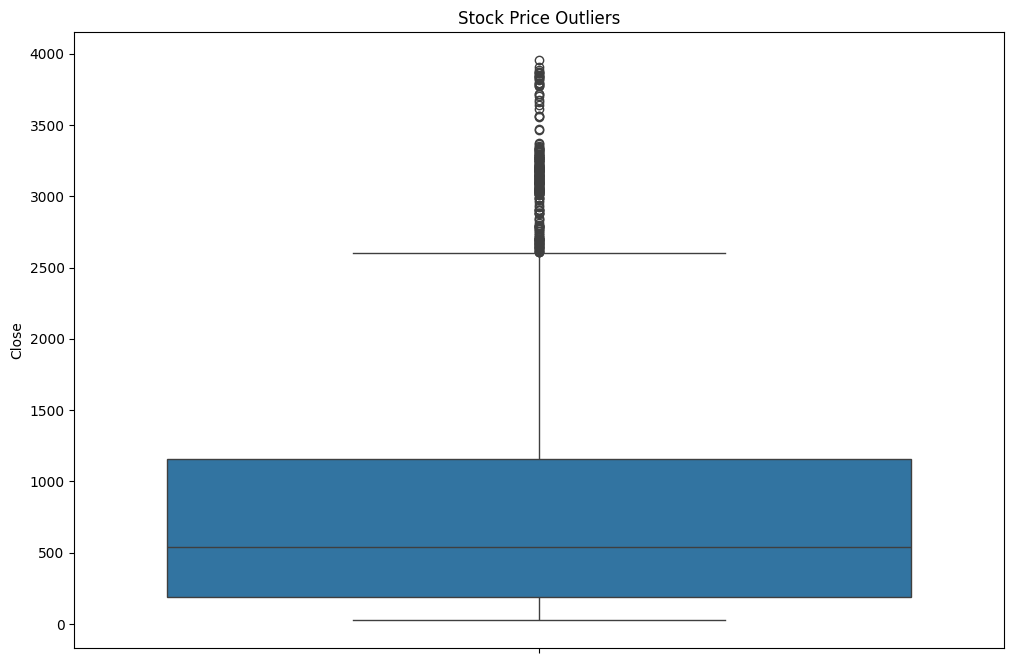

In [48]:
# Outlier Detection
plt.figure(figsize=(12, 8))
sns.boxplot(y=df['Close'])
plt.title('Stock Price Outliers')
plt.show()

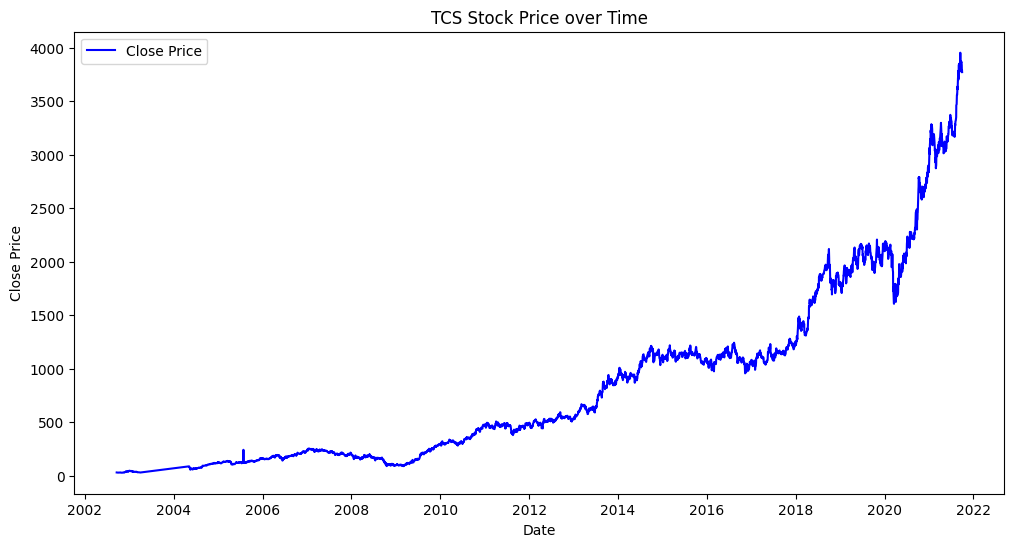

In [49]:
# time series plot
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close Price',color='b')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('TCS Stock Price over Time')
plt.legend()

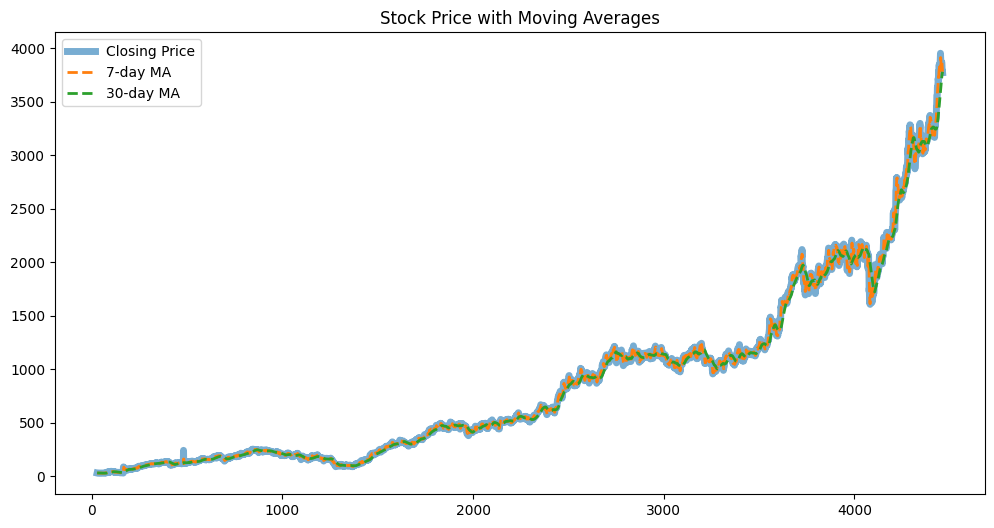

In [50]:
# Stock Price with Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Closing Price', alpha=0.6, linewidth = 5)
plt.plot(df['MA_3'], label='7-day MA', linestyle='dashed', linewidth=2)
plt.plot(df['MA_30'], label='30-day MA', linestyle='dashed', linewidth=2)
plt.title('Stock Price with Moving Averages')
plt.legend()
plt.show()

## Linear Regression

In [51]:
# Prepare the data
X = df[['Low', 'High', 'Open']]  # Using these features to predict Close
y = df['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  

# Create and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Model Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared Score: {r2:.2f}")


Linear Regression Model Performance:
Mean Squared Error: 209.60
Mean Absolute Error: 10.37
R-squared Score: 1.00


In [52]:
#Feature importance
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(coefficients)


Feature Importance:
  Feature  Coefficient
1    High   321.996624
0     Low   285.821923
2    Open  -198.155387


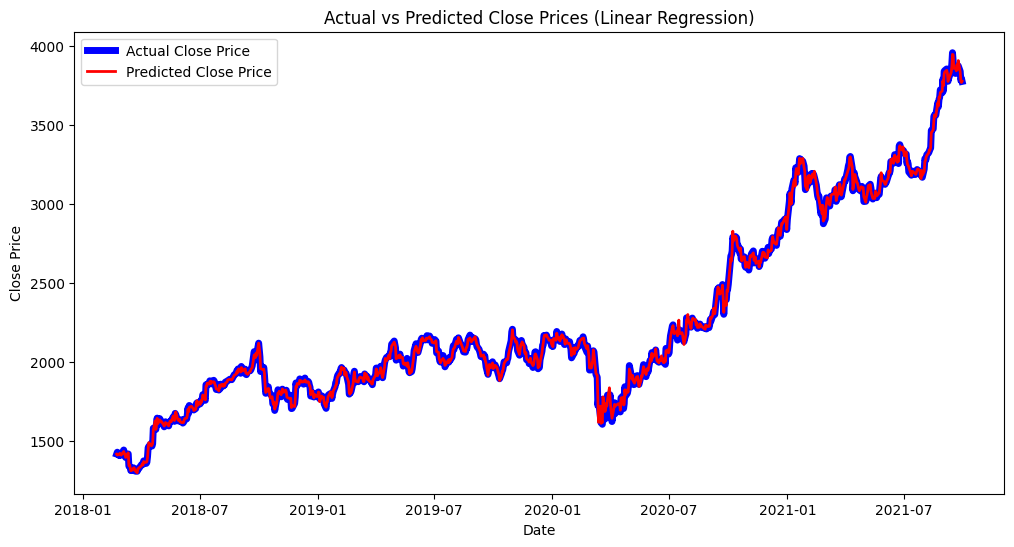

In [53]:
# Visualize the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-len(y_test):], y_test.values, label='Actual Close Price', color='blue', linewidth=5)
plt.plot(df['Date'][-len(y_test):], y_pred, label='Predicted Close Price', color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices (Linear Regression)')
plt.legend()
plt.show()

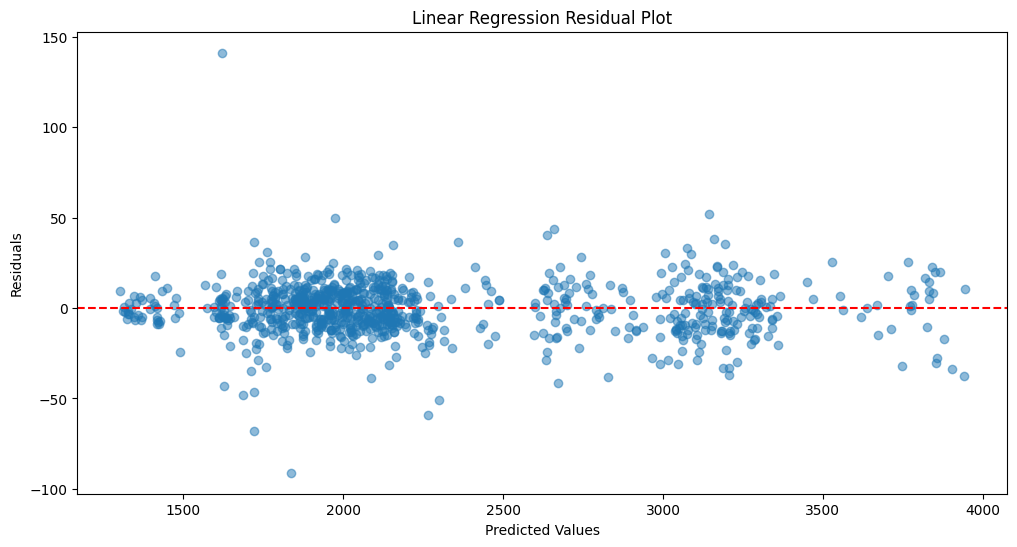

In [54]:
# residuals
residuals_lr = y_test - y_pred
plt.figure(figsize=(12,6))
plt.scatter(y_pred, residuals_lr, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Linear Regression Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

---
## XGBoost

In [55]:
correlation_with_close= df.corr()['Close'].sort_values(ascending=False)
print(correlation_with_close)

Close           1.000000
High            0.999914
Low             0.999901
MA_3            0.999859
Open            0.999785
Close_t-1       0.999739
MA_7            0.999559
Close_t-2       0.999496
EMA_12          0.999411
MA_14           0.999007
EMA_26          0.998722
MA_30           0.997856
Date            0.900255
Volatility      0.781762
MACD            0.423443
RSI             0.085723
Price_Change    0.066729
Dividends       0.059891
Stock Splits   -0.006829
Volume         -0.157727
Name: Close, dtype: float64


In [56]:
# Select relevant features
features = ['Low', 'High', 'Open','Close_t-1', 'MA_3', 'MA_7', 'MA_14', 'MA_30', 
            'EMA_12', 'EMA_26', 'MACD', 'RSI', 'Price_Change', 'Volatility']

X = df[features]
y = df['Close']

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()

# Define hyperparameter grid
"""param_grid = {
    'n_estimators': [100, 300, 500],    
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 4, 5, 6],              
    'subsample': [0.6, 0.8, 1.0],             
    'colsample_bytree': [0.6, 0.8, 1.0]       
}"""

# Initialize XGBoost model
xgb_model = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror', eval_metric='rmse')
#random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter=100, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=0)

best_xgb = XGBRegressor(
    subsample=0.8, 
    n_estimators=300, 
    max_depth=3, 
    learning_rate=0.1, 
    colsample_bytree=1.0, 
    random_state=42, 
    n_jobs=-1, 
    objective='reg:squarederror', 
    eval_metric='rmse'
)

best_r2 = float('-inf')
best_X_train, best_X_test, best_y_train, best_y_test, best_model, best_y_pred = None, None, None, None, None, None

# Iterate through splits
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply scaling
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit hyperparameter search
    best_xgb.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=0)

    # Get the best model : best_xgb = best_xgb.best_estimator_

    # Make predictions
    y_pred_xgb = best_xgb.predict(X_test_scaled)

    # Evaluate model performance
    r2 = r2_score(y_test, y_pred_xgb)

    # Track the best split
    if r2 > best_r2:
        best_r2 = r2
        best_X_train, best_X_test, best_y_train, best_y_test = X_train_scaled, X_test_scaled, y_train, y_test
        best_model, best_y_pred = best_xgb, y_pred_xgb

# Display best model performance
print(f"XGBoost Model Performance:")
print(f"Mean Squared Error: {mean_squared_error(best_y_test, best_y_pred):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(best_y_test, best_y_pred):.2f}")
print(f"R-squared Score: {best_r2:.2f}")
#print("Best Parameters:", random_search.best_params_)

XGBoost Model Performance:
Mean Squared Error: 362.99
Mean Absolute Error: 11.41
R-squared Score: 0.83


<Figure size 1200x600 with 0 Axes>

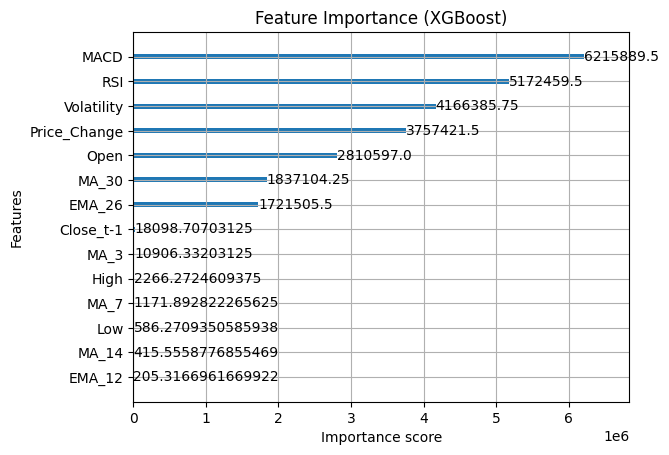

In [57]:
# Feature importance visualization
importances = best_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plot_importance(best_model, importance_type='gain')
plt.yticks(range(len(feature_imp_df)), feature_imp_df['Feature'])
plt.title("Feature Importance (XGBoost)")
plt.show()

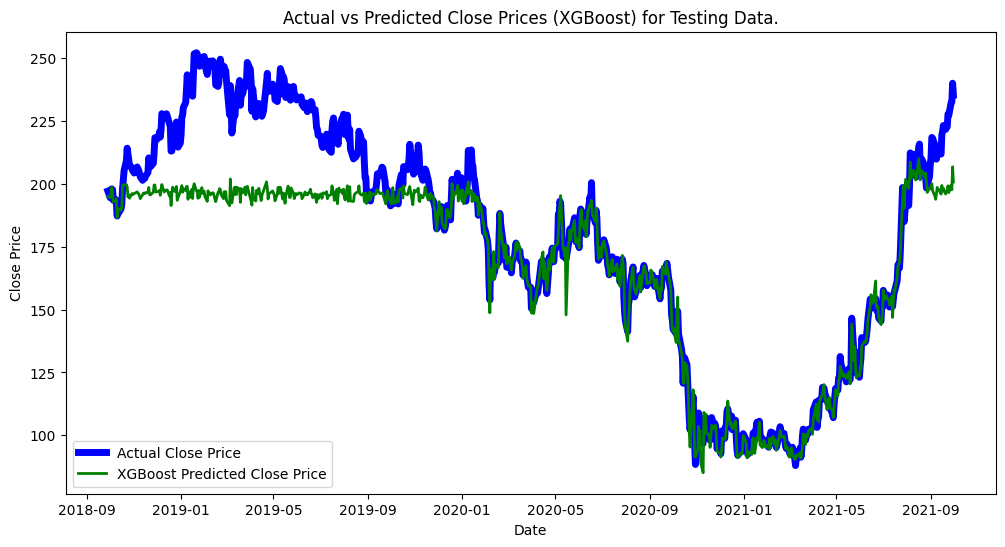

In [58]:
# Plot actual vs predicted stock prices for test data
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-len(best_y_test):], best_y_test.values, label='Actual Close Price', color='blue', linewidth=5)
plt.plot(df['Date'][-len(best_y_test):], best_y_pred, label='XGBoost Predicted Close Price', color='green', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices (XGBoost) for Testing Data.')
plt.legend()
plt.show()

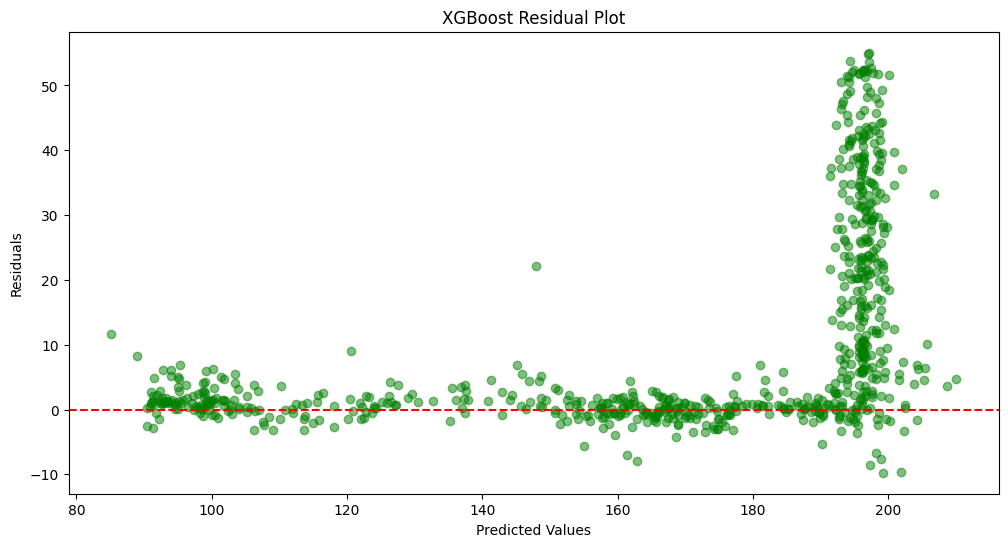

In [59]:
# residuals
residuals_xgb = best_y_test - best_y_pred
plt.figure(figsize=(12,6))
plt.scatter(best_y_pred, residuals_xgb, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('XGBoost Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


---
## Prophet

In [60]:
prophet_df = df[['Date', 'Open', 'High', 'Low', 'MA_3', 'MA_7', 'Close_t-2', 'Close_t-1',
            'Price_Change', 'Volatility', 'MA_14', 'MA_30', 'EMA_12', 'EMA_26', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Initialize Prophet model
model = Prophet(changepoint_prior_scale=0.05, 
                seasonality_prior_scale=10, 
                yearly_seasonality=True)
model.fit(prophet_df)
# Create future dates for prediction (next 30 days)
future_dates = model.make_future_dataframe(periods=30)

# Forecast future values
forecast = model.predict(future_dates)

# Merge actual vs predicted values for evaluation
df_eval = forecast[['ds', 'yhat']].merge(prophet_df, on='ds', how='left')

# Drop NaN values (for historical predictions)
df_eval.dropna(inplace=True)

# Compute error metrics
mae = mean_absolute_error(df_eval['y'], df_eval['yhat'])
rmse = np.sqrt(mean_squared_error(df_eval['y'], df_eval['yhat']))
r2 = r2_score(df_eval['y'], df_eval['yhat'])

print(f"Prophet Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared Score: {r2:.2f}")


18:17:06 - cmdstanpy - INFO - Chain [1] start processing
18:17:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Evaluation:
Mean Absolute Error (MAE): 67.67
Root Mean Squared Error (RMSE): 129.07
R-squared Score: 0.98


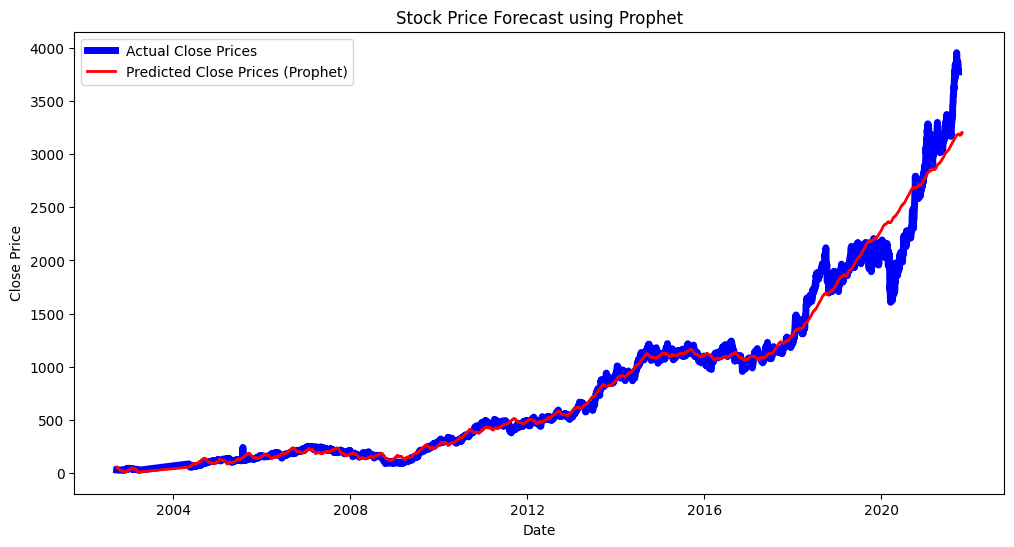

In [61]:
# Visualization: Actual vs. Predicted Stock Prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label="Actual Close Prices", color='blue', linewidth=5)
plt.plot(forecast['ds'], forecast['yhat'], label="Predicted Close Prices (Prophet)", color='red', linewidth=2)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Price Forecast using Prophet")
plt.legend()
plt.show()

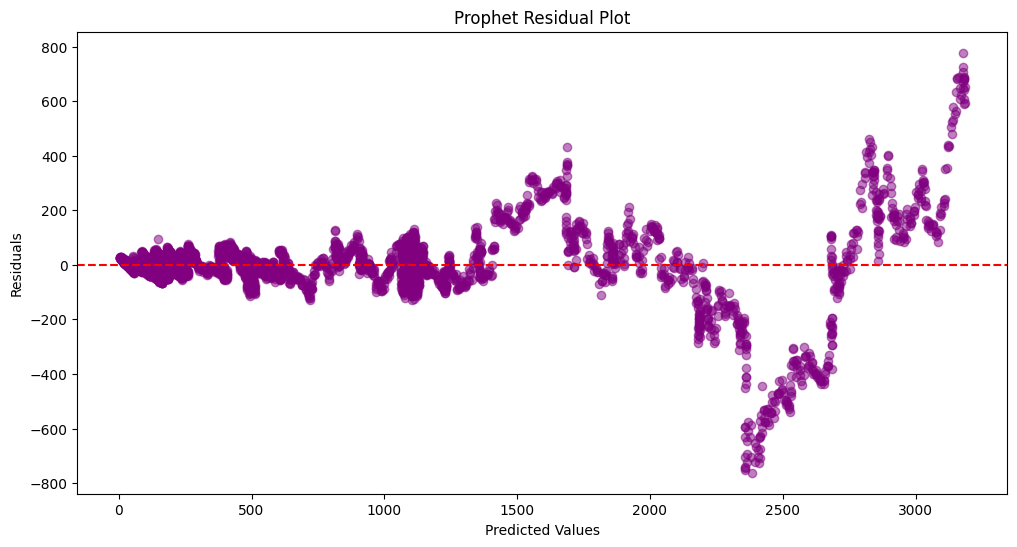

In [62]:
# Residuals
residuals_prophet = df_eval['y'] - df_eval['yhat']
plt.figure(figsize=(12,6))
plt.scatter(df_eval['yhat'], residuals_prophet, alpha=0.5, color='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Prophet Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()